[![logo](https://raw.githubusercontent.com/ecmwf-training/cams-act6/main/images/logoline.png)](https://atmosphere.copernicus.eu/6th-ecmwf-cams-esa-eumetsat-training-atmospheric-composition)

# CAMS Regional Air Quality Forecast Practical

**Run the tutorial via free cloud platforms**: [![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/cams-act6/main?labpath=03-model/cams-regional-forecast.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/cams-act6/blob/main/03-model/cams-regional-forecast.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/cams-act6/blob/main/03-model/cams-regional-forecast.ipynb)


## Learning objectives

In this practical exercise you will download CAMS Regional Air Quality Forecast data. You will then calculate the daily max and mean values from a 96 hour forecast of surface ozone concentration and plot these as maps. Finally, you will create a chart of the full 96 hour time series over a specific location.

## Initial setup

Before we begin we must prepare our environment. This includes installing the Application Programming Interface (API) of the Atmosphere Data Store (ADS), intalling any other packages not already installed, setting up our ADS API credentials and importing the various Python libraries that we will need.

In [1]:
# Ensure that the cdsapi package is installed
!pip install -q cdsapi

In [2]:
# If you are running this notebook in Colab, uncomment the line below and run this cell.
#!pip install cartopy

### Add your ADS API credentials

To set up your ADS API credentials, please login/register on the [ADS](https://ads-beta.atmosphere.copernicus.eu/), then you will see your [unique API key here](https://ads-beta.atmosphere.copernicus.eu/how-to-api). 

You can add this API key to your current session by replacing `#########` in the code cell below with your API key.

In [3]:
import os
os.environ['CDSAPI_URL'] = 'https://ads-beta.atmosphere.copernicus.eu/api'
os.environ['CDSAPI_KEY'] = '###########################################'

### Import libraries

In [4]:
# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import pandas as pd
import xarray as xr

# Manipulate dates and times
import datetime

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

Here you specify a data directory in which you will download your data and all output files that you will generate:

In [5]:
DATADIR = '.'

## Explore and download data

The download form for the CAMS regional forecast data can be found here https://ads-beta.atmosphere.copernicus.eu/datasets/cams-europe-air-quality-forecasts?tab=download. However, we will download the data programmatically, using the parameters specified in the following code cells. 

**Please remember to accept the terms and conditions at the bottom of the download form.**


### Specify parameters of data request

In [6]:
cams_dataset = 'cams-europe-air-quality-forecasts'
start_date = '2024-07-30'
end_date = '2024-07-30'
time = '00:00'
lead_time_start = 0
lead_time_stop = 96
step_hours = 1
leadtime_hours = list(range(lead_time_start, lead_time_stop + lead_time_start, step_hours))
variables = ['ozone']
models = ['ensemble']
levels = [0]

### Create dictionary of request

In [7]:
request = {
        'variable': variables,
		'date': f'{start_date}/{end_date}',
        'time': f'{time}',
        'leadtime_hour': leadtime_hours,
        'type': 'forecast',
        'model': models,
        'level': levels,
        'data_format': 'netcdf'
    }

### Download data

In [8]:
target = f'{DATADIR}/O3-regional-forecast-20240730.nc'

In [9]:
c = cdsapi.Client()
c.retrieve(cams_dataset, request).download(target)

2024-09-12 12:39:58,410 INFO Request ID is ef7a2da1-f8f4-4e94-a98f-833025be52db
2024-09-12 12:39:58,657 INFO status has been updated to accepted
2024-09-12 12:40:00,405 INFO status has been updated to running
2024-09-12 12:40:48,629 INFO status has been updated to successful


b9ac356535d7ee6c47c033c13596d218.nc:   0%|          | 0.00/108M [00:00<?, ?B/s]

'./O3-regional-forecast-20240730.nc'

## Inspect data

In [10]:
# Create Xarray Dataset
ds = xr.open_dataset(target)

# view the dataset
ds

<xarray.Dataset> Size: 113MB
Dimensions:    (longitude: 700, latitude: 420, level: 1, time: 96)
Coordinates:
  * longitude  (longitude) float32 3kB 335.0 335.1 335.2 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 2kB 71.95 71.85 71.75 ... 30.25 30.15 30.05
  * level      (level) float32 4B 0.0
  * time       (time) timedelta64[ns] 768B 00:00:00 01:00:00 ... 3 days 23:00:00
Data variables:
    o3_conc    (time, level, latitude, longitude) float32 113MB ...
Attributes:
    title:        O3 Air Pollutant FORECAST at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE FORECAST
    FORECAST:     Europe, 20240730+[0H_95H]
    summary:      ENSEMBLE model hourly FORECAST of O3 concentration at the S...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

## Process data

Here you will calculate the daily forecast maximum and mean values. Before doing so, we will carry-out some processing to more easily manage the time dimension.

### Convert time dimension to datetime

In [11]:
delta_forecast = 3600000000000 # delta between one lead time and the next one
num_forecasts = len(leadtime_hours) 
start_day = pd.to_datetime(start_date)
forecast_index = start_day + pd.to_timedelta(np.arange(num_forecasts), 'H')

/tmp/ipykernel_36/2626879120.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  forecast_index = start_day + pd.to_timedelta(np.arange(num_forecasts), 'H')


In [12]:
ds_dt = ds.assign_coords(time=forecast_index)
ds_dt

<xarray.Dataset> Size: 113MB
Dimensions:    (longitude: 700, latitude: 420, level: 1, time: 96)
Coordinates:
  * longitude  (longitude) float32 3kB 335.0 335.1 335.2 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 2kB 71.95 71.85 71.75 ... 30.25 30.15 30.05
  * level      (level) float32 4B 0.0
  * time       (time) datetime64[ns] 768B 2024-07-30 ... 2024-08-02T23:00:00
Data variables:
    o3_conc    (time, level, latitude, longitude) float32 113MB ...
Attributes:
    title:        O3 Air Pollutant FORECAST at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE FORECAST
    FORECAST:     Europe, 20240730+[0H_95H]
    summary:      ENSEMBLE model hourly FORECAST of O3 concentration at the S...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

In [13]:
# create xarray data array object (single variable)
da = ds_dt['o3_conc']
da

<xarray.DataArray 'o3_conc' (time: 96, level: 1, latitude: 420, longitude: 700)> Size: 113MB
[28224000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 3kB 335.0 335.1 335.2 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 2kB 71.95 71.85 71.75 ... 30.25 30.15 30.05
  * level      (level) float32 4B 0.0
  * time       (time) datetime64[ns] 768B 2024-07-30 ... 2024-08-02T23:00:00
Attributes:
    species:        Ozone
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_ozone_in_air

### Calculate daily max and mean concentrations

In [14]:
o3_daily_max = da.resample(time='D').max()
o3_daily_mean = da.resample(time='D').mean()

## Plot forecast maps

In [15]:
def plot_forecasts(xarray_da, num_forecasts, plot_title):
    '''
    Creates a plot of a data array
    '''
    fig, axs = plt.subplots(4, 1, figsize = (10, 40), 
                            subplot_kw={'projection': ccrs.Orthographic(central_latitude=60)})
    
    day_forecasts = xarray_da.time.values
    for i in range(num_forecasts):
        timestamp = day_forecasts[i]
        day = str(timestamp)[:10]
        data = xarray_da.sel(time=day, level=0.0)
        cs = axs[i].pcolormesh(xarray_da.longitude, 
                               xarray_da.latitude, 
                               data,  
                               cmap='RdYlBu_r', #'YlOrRd' 
                               transform=ccrs.PlateCarree())
    
        cbar = plt.colorbar(cs, fraction=0.046, pad=0.05, orientation='vertical', shrink=0.75)
        cbar.set_label(' $\mu g \cdot m^{-3}$')
        axs[i].set_title(plot_title + day)
        axs[i].coastlines(color='black', alpha=0.7) 
        axs[i].gridlines(draw_labels=False, linestyle='--')
        axs[i].margins(0.5)

/opt/conda/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


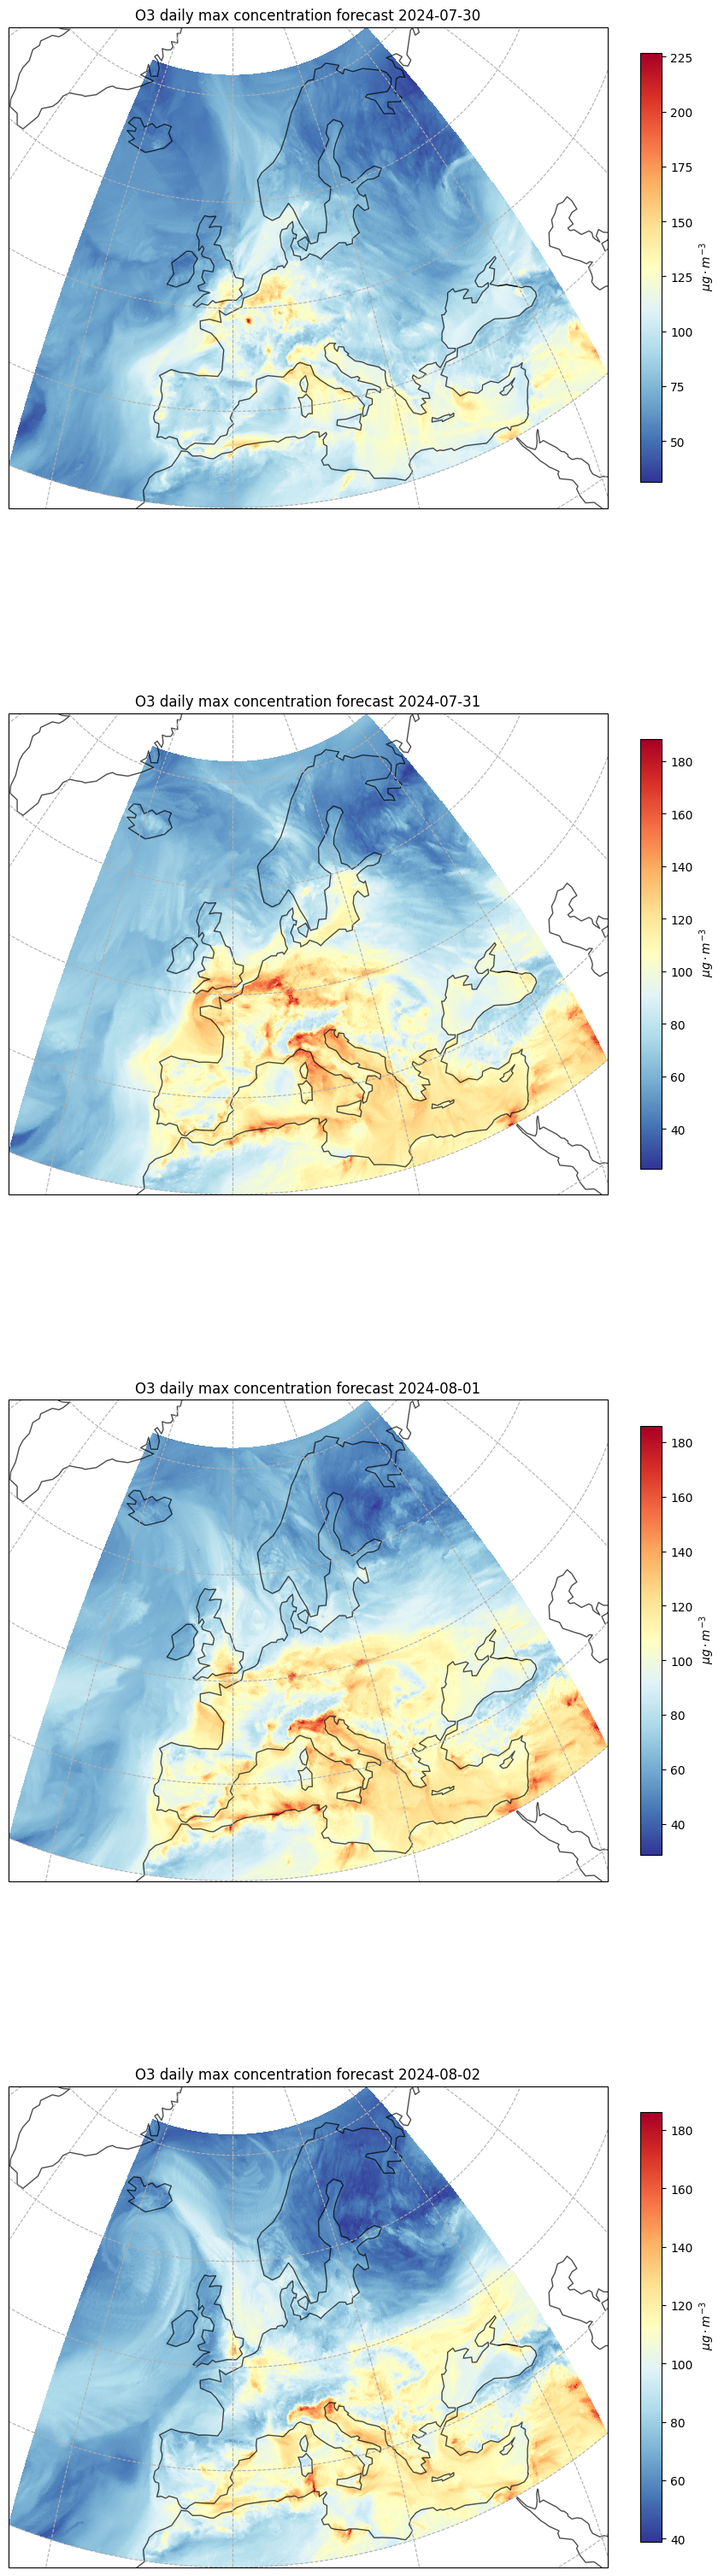

In [16]:
plot_forecasts(o3_daily_max, 4, 'O3 daily max concentration forecast ')

## Plot time series for given latitude and longitude

### Convert longitude to [-180, 180] grid

Notice that the `longitude` variables in the Xarray Dataset and Data Array objects are in the range of `[0, 359.75]`. By default, ECMWF data are on a [0, 360] grid. Should you wish to, there are two options to bring the longitude coordinates to a `[-180, 180]` grid. The first option, in case you already have the data downloaded, is to assign values to coordinates with the xarray function `assign_coords()`. The code below shifts your longitude coordinates from `[0, 359.75]` to `[-180, 179.75]`.

The second option is to specify the `area` keyword argument right when you request data with the `CDS API`. The `area` keyword then automatically reprojects the requested data onto a [-180, 180] grid.

In [17]:
ds_180 = ds_dt.assign_coords(longitude=(((ds_dt.longitude + 180) % 360) - 180)).sortby('longitude')

In [18]:
da = ds_180['o3_conc']
da

<xarray.DataArray 'o3_conc' (time: 96, level: 1, latitude: 420, longitude: 700)> Size: 113MB
[28224000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 2kB 71.95 71.85 71.75 ... 30.25 30.15 30.05
  * level      (level) float32 4B 0.0
  * time       (time) datetime64[ns] 768B 2024-07-30 ... 2024-08-02T23:00:00
  * longitude  (longitude) float32 3kB -24.95 -24.85 -24.75 ... 44.85 44.95
Attributes:
    species:        Ozone
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_ozone_in_air

### Select location

In [19]:
oslo_lat = 59.91 
oslo_lon = 10.73

In [20]:
oslo_da = da.sel(latitude = oslo_lat, longitude = oslo_lon, method='nearest', level=0.0)
oslo_da

<xarray.DataArray 'o3_conc' (time: 96)> Size: 384B
[96 values with dtype=float32]
Coordinates:
    latitude   float32 4B 59.95
    level      float32 4B 0.0
  * time       (time) datetime64[ns] 768B 2024-07-30 ... 2024-08-02T23:00:00
    longitude  float32 4B 10.75
Attributes:
    species:        Ozone
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_ozone_in_air

### Plot time series

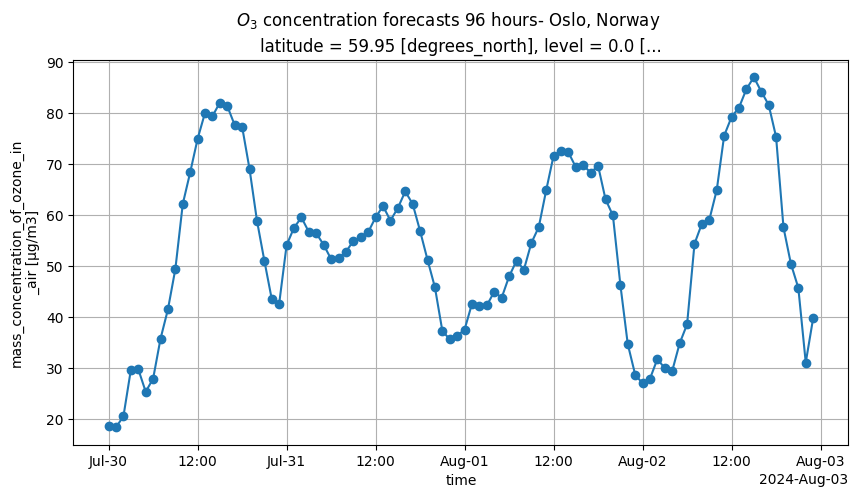

In [21]:
fig = plt.figure(figsize=(10, 5))
oslo_da.plot(marker='o')
plt.suptitle("$O_3$ concentration forecasts 96 hours- Oslo, Norway")
plt.grid(True)

For more analysis of this event, visit https://atmosphere.copernicus.eu/cams-air-boreal-summer-24